# Recurrent Neural Networks

RNNs are a family of neural networks for processing sequential data. 

We have seen how convolutional neural networks are specialized in processing a grid of values $X$. In the same way, RNNs are specialized in processing a sequence of values $x^{(1)}, x^{(2)}, \dots, x^{(\tau)}$. 

To go from MLP to RNN, we again need to take advantage of parameter sharing so that we can process sequences of arbitrary length (just like we did with CNNs for images of arbitrary size). In other words, if we used an MLP, the input layer has a fixed dimensionality, which we do not want. Some sequences may be shorter or longer than other sequences. 

Of course, we could use a 1-D convolution operation on a sequence of data, for which parameter sharing is still applied and this approach is scalable to arbitrary sequence lengths. This is actually the basis for [time-delay networks](https://en.wikipedia.org/wiki/Time_delay_neural_network). However, this type of parameter sharing is not the same as that of RNNs. Using a 1-D convolution means that the output is a product of the input and a small neighbourhood around the input at each time point of the sequence. RNNs instead compute the output based on every single input that came before a specific time step. 

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import numpy as np

## Sequential models

Before delving into RNNs, let's specify what we mean by sequence modeling. A very naive approach is to look at the last $\tau$ instances to predict the next instance in the sequence. 

This type of sequence model is called a **Markov chain model**, and mathematically, it is defined as:

$P(y^{(t+1)} \;|\; y^{(t)}, y^{(t-1)}, \dots, y^{(t-\tau-1)}, y^{(t-\tau)})$

In other words, it models the probability of an output $y$ at time step $t+1$ based on all previous $y$ outputs from time step $t$ to $t-\tau$.

For example, if $\tau = 3$, we get

$P(y^{(t+1)} \;|\; y^{(t)}, y^{(t-1)}, y^{(t-2)}, y^{(t-3)})$

- The conditioning set $\{y^{(t)}, y^{(t-1)}, y^{(t-2)}, y^{(t-3)}\}$ of this probability can be seen as the **input** to our model. 
- The value we are calculating the probability over, i.e., $y^{(t+1)}$ can be seen as the **output** of our model.
- The probability function itself can be seen as the **model** we are attempting to approximate. 

Since our inputs and output always have a fixed length, we can use a linear regression model to predict the relationship between inputs and output.  

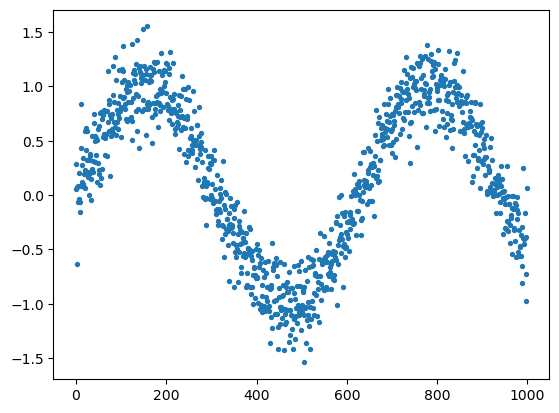

In [2]:
# let's generate a sine wave sequence with a bit of noise
N = 1000
x = torch.arange(0, N, 1)
y = torch.sin(0.01 * x) + torch.normal(0, 1, size=(N,)) * 0.2

plt.scatter(x, y, s=8)

Here, we implement our own linear regression model using PyTorch

In [3]:
from torch.utils.data import DataLoader
from torch.optim import SGD

class LinearRegression(nn.Module):
    def __init__(self, alpha=0.1, batch_size=32, epochs=10, learning_rate=0.01) -> None:
        super().__init__()
        self.alpha = alpha                      # regularization parameter
        self.batch_size = batch_size            # number of batches to process at one time
        self.epochs = epochs                    # number of epochs to train the model
        self.learning_rate = learning_rate      # optimization step size
        self.net = nn.LazyLinear(1)             # simple linear layer
        self.net.weight.data.normal_(0, 0.01)   # initialize weights to be gaussian N(0, 0.01)
        self.net.bias.data.fill_(0)             # initialize bias to be zero
        self.criterion = nn.MSELoss()           # loss criterion is MSE
        self.losses = None
    
    def forward(self, X):
        return self.net(X)

    def loss(self, y_hat, y):
        return self.criterion(y_hat, y)
    
    def fit(self, X: torch.Tensor, y: torch.Tensor):
        self.losses = []
        
        # weight_decay parameter ensures regularization, meaning the magnitude of the weight is contrained to be small
        optim = SGD(self.net.parameters(), self.learning_rate, weight_decay=self.alpha)

        # create simple training set
        training_set = torch.cat([X, y.reshape(-1, 1)], dim=1)
        train_dataloader = DataLoader(training_set, self.batch_size, shuffle=True)

        for _ in range(self.epochs):
            
            batch_loss = []
            for batch in train_dataloader:
                # last column is the output
                train_X = batch[:, :-1]
                train_y = batch[:, -1].reshape(-1, 1)

                y_hat = self.net(train_X)

                loss = self.loss(y_hat, train_y)
                batch_loss.append(loss.item())

                # optimization step
                loss.backward()
                optim.step()
                optim.zero_grad()
                
            self.losses.append(sum(batch_loss) / len(batch_loss))

        return self

Using a linear regression we can model a sequence with the length of the context history $\tau=3$

c:\Users\janba\anaconda3\envs\workspace_jan\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


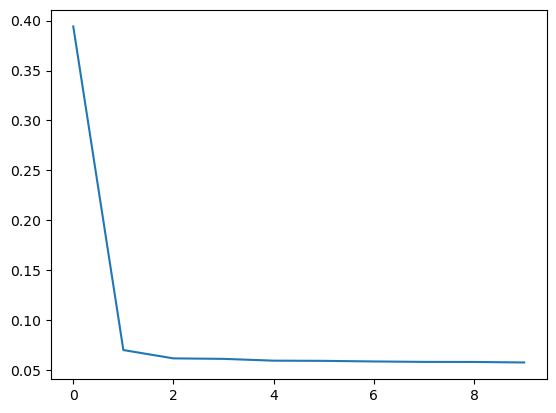

In [4]:
tau = 3
# we take a sliding window over the dataset and create samples of inputs to the model
x_train = torch.cat([y[i : i + tau][None, :] for i in range(N-tau)], dim=0)
y_train = torch.cat([y[i+tau][None] for i in range(N-tau)])

# create and fit model
model = LinearRegression(batch_size=16, epochs=10)
model.fit(x_train, y_train)

plt.plot(model.losses)

We can see that looking 1 step into the future leads to a good model

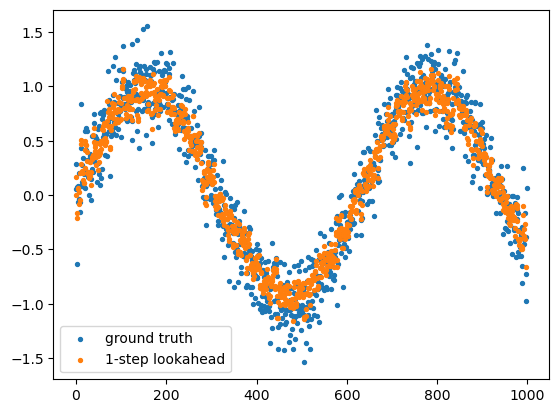

In [5]:
y_pred = model(x_train)
plt.scatter(x, y, s=8, label='ground truth')
plt.scatter(range(N-tau), y_pred.detach().numpy(), s=8, label='1-step lookahead')
plt.legend()

However, a big problem is that looking further into the future leads to accumulation of cumulative error, which causes very bad predictions.

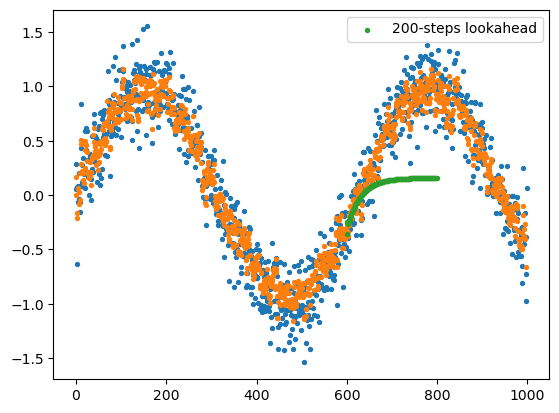

In [6]:
def look_k_steps_into_future(model, k, tau, x_instance):
    # concatenate predictions to make the next predictions
    for _ in range(k-tau):
        y_pred = model(x_instance[-tau:]).detach()
        x_instance = torch.cat([x_instance, y_pred])
    return x_instance

start = 600
steps = 200
future_preds = look_k_steps_into_future(model, steps, tau, x_train[start])

plt.scatter(x, y, s=8)
plt.scatter(range(N-tau), y_pred.detach().numpy(), s=8)
plt.scatter(range(start, start+steps), future_preds, s=8, label=f'{steps}-steps lookahead')
plt.legend()

## Basic RNN module

Maps input sequence to output sequence using update equations for each time step $t=1$ to $t = \tau$
\begin{align*}
    \textbf{a}^{(t)} &= \textbf{b} + \textbf{W}\textbf{h}^{(t-1)} + \textbf{U}\textbf{x}^{(t)}\\
    \textbf{h}^{(t)} &= \text{tanh}(\textbf{a}^{(t)})\\
    \hat{\textbf{y}}^{(t)} &= \text{softmax}(\textbf{c} + \textbf{V}\textbf{h}^{(t)})
\end{align*}
for 
- shared bias vectors $\textbf{b}, \textbf{c}$
- shared weight matrices:
  - $\textbf{W}$: hidden-to-hidden weights
  - $\textbf{U}$: input-to-hidden
  - $\textbf{V}$: hidden-to-output
- and input vectors $\textbf{x} \in \textbf{X}$

PyTorch handles the mathematics in an efficient way. In the following we define a custom torch module that contains the RNN as well as a linear layer followed by a softmax layer. This allows us to output a distribution of possible outputs for each sequence.   

In [7]:
class MyRNN(nn.Module):
    def __init__(self, 
                 num_inputs: int, 
                 num_hidden: int, 
                 num_outputs: int, 
                 n_layers: int,
                 dropout: float = 0.5) -> None:
        super().__init__()
        self.rnn = nn.RNN(num_inputs, num_hidden, num_layers=n_layers, dropout=dropout)
        self.out = nn.Sequential(nn.LazyLinear(num_outputs), nn.Softmax(dim=1))
    
    def forward(self, X: torch.Tensor, H: torch.Tensor = None, temperature: float = 1.0):
        output, H = self.rnn(X, H)
        return self.out(output / temperature).swapaxes(0, 1), H

    def predict(self, prefix: str, num_preds: int, encoding, unique_vals, temperature):
        prefix = prefix.lower().split() if len(max(unique_vals.tolist(), key=lambda x: len(x))) > 1 else list(prefix.lower())
        H, outputs = None, [torch.tensor(encoding[prefix[0]].reshape(1, -1), dtype=torch.float32).to('cuda')]

        for i in range(len(prefix) + num_preds - 1):
            # print(outputs[-1].shape)
            Y, H = self.forward(outputs[-1], H, temperature)
            # print(Y.shape, H.shape)

            if i < len(prefix) - 1:
                outputs.append(torch.tensor(encoding[prefix[i+1]].reshape(1, -1), dtype=torch.float32).to('cuda'))
            else:
                outputs.append(Y.reshape(1, -1))
        
        return ' '.join([unique_vals[y.cpu().argmax(dim=1)] for y in outputs])

## Sequence Dataset

- X: sequence of one-hot vectors of either characters or words
- Y: same sequence but shifted to the right by 1

Usage: language model that predicts the next token based on context window `seq_len`

### Character level dataset

In [9]:
from torch.utils.data import DataLoader, Dataset
import re

class SeqCharacterDataset(Dataset):
    def __init__(self, file_path, seq_len=3, is_train=True) -> None:
        f = open(file_path, 'r')
        corpus = f.read()
        corpus = re.sub('[^A-Za-z]+', ' ', corpus).lower()

        len_corpus = len(corpus)
        if is_train:
            corpus = corpus[:int(0.8*len_corpus)]
        else:
            corpus = corpus[int(0.8*len_corpus):]

        self.unique_chars = np.unique(list(''.join(corpus)))
        self.encoding = {k:np.eye(len(self.unique_chars))[i] for i, k in enumerate(self.unique_chars)}

        X = []
        Y = []
        for i in range(len(corpus)-seq_len):       
            x = [self.encoding[c] for c in corpus[i:i+seq_len]]
            y = [self.encoding[c] for c in corpus[i+1:i+seq_len+1]]
            X.append(x)
            Y.append(y)

        self.X = torch.tensor(np.array(X, dtype='float32'))
        self.Y = torch.tensor(np.array(Y, dtype='float32'))
        
    def __getitem__(self, index):
        return self.X[index], self.Y[index]

    def __len__(self):
        return len(self.X)

In [52]:
dataset = SeqCharacterDataset("../datasets/shakespeare.txt", seq_len=3, is_train=True)
dataset.X.shape, dataset.Y.shape

(torch.Size([847661, 3, 27]), torch.Size([847661, 3, 27]))

In [53]:
dataset = SeqCharacterDataset("../datasets/shakespeare.txt", seq_len=3, is_train=False)
dataset.X.shape, dataset.Y.shape

(torch.Size([211914, 3, 27]), torch.Size([211914, 3, 27]))

In [55]:
seq_len = 3
dataset = SeqCharacterDataset("../datasets/shakespeare.txt", seq_len=seq_len)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, drop_last=True)

x, y = next(iter(dataloader))
x.shape, y.shape

(torch.Size([16, 3, 27]), torch.Size([16, 3, 27]))

### Word level dataset

In [42]:
from torch.utils.data import DataLoader, Dataset
import re

class SeqWordDataset(Dataset):
    def __init__(self, file_path, seq_len=3) -> None:
        f = open(file_path, 'r')
        corpus = f.read()
        corpus = re.sub('[^A-Za-z]+', ' ', corpus).lower().split()

        self.unique_words = np.unique(corpus)
        self.encoding = {k:np.eye(len(self.unique_words))[i] for i, k in enumerate(self.unique_words)}
        
        X = []
        Y = []
        for i in range(len(corpus)-seq_len):       
            x = [self.encoding[w] for w in corpus[i:i+seq_len]]
            y = [self.encoding[w] for w in corpus[i+1:i+seq_len+1]]
            X.append(x)
            Y.append(y)

        X = torch.tensor(np.array(X, dtype='float32'))
        Y = torch.tensor(np.array(Y, dtype='float32'))
        self.data = torch.cat([X, Y], dim=1)

    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return len(self.data)

In [43]:
seq_len = 3
dataset = SeqWordDataset("../datasets/1984chapter.txt", seq_len=seq_len)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, drop_last=True)

next(iter(dataloader)).shape

torch.Size([16, 6, 521])

## RNN with Pytorch primitives

In [20]:
class MyRNN(nn.Module):
    def __init__(self, 
                 num_inputs: int, 
                 num_hidden: int, 
                 num_outputs: int, 
                 n_layers: int,
                 dropout: float = 0.5) -> None:
        super().__init__()
        self.rnn = nn.RNN(num_inputs, num_hidden, num_layers=n_layers, dropout=dropout)
        self.out = nn.Sequential(nn.LazyLinear(num_outputs), nn.Softmax(dim=1))
    
    def forward(self, X: torch.Tensor, H: torch.Tensor = None, temperature: float = 1.0):
        output, H = self.rnn(X, H)
        return self.out(output / temperature).swapaxes(0, 1), H

    def predict(self, prefix: str, num_preds: int, encoding, unique_vals, temperature):
        prefix = prefix.lower().split() if len(max(unique_vals.tolist(), key=lambda x: len(x))) > 1 else list(prefix.lower())
        H, outputs = None, [torch.tensor(encoding[prefix[0]].reshape(1, -1), dtype=torch.float32).to('cuda')]

        for i in range(len(prefix) + num_preds - 1):
            # print(outputs[-1].shape)
            Y, H = self.forward(outputs[-1], H, temperature)
            # print(Y.shape, H.shape)

            if i < len(prefix) - 1:
                outputs.append(torch.tensor(encoding[prefix[i+1]].reshape(1, -1), dtype=torch.float32).to('cuda'))
            else:
                outputs.append(Y.reshape(1, -1))
        
        return ''.join([unique_vals[y.cpu().argmax(dim=1)] for y in outputs])

### Character level model

In [70]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
EPOCHS = 50

seq_len = 20
dataset = SeqCharacterDataset("../datasets/shakespeare.txt", seq_len=seq_len)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, drop_last=True)

n_input = len(dataset.unique_chars)
n_hidden = 64
rnn = MyRNN(
    num_inputs=n_input, 
    num_hidden=n_hidden, 
    num_outputs=n_input, 
    n_layers=2,
    dropout=0.5
).to(DEVICE)

optim = torch.optim.AdamW(rnn.parameters(), 0.0002)

losses = []

for i in range(EPOCHS):
    batch_loss = []
    for batch_X, batch_y in dataloader:
        batch_X = batch_X.transpose(0, 1).to(DEVICE)
        batch_y = batch_y.to(DEVICE)
        
        optim.zero_grad()
        y_pred, _ = rnn(batch_X)
        loss = F.cross_entropy(y_pred, batch_y)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
        optim.step()

        batch_loss.append(loss.detach().item())

    losses.append(np.sum(batch_loss) / len(batch_loss))
    print(f"epoch={i}\tloss={losses[-1]}")

plt.plot(losses)

epoch=0	loss=2.163611422939554
epoch=1	loss=2.151410015732527
epoch=2	loss=2.1478965202871314
epoch=3	loss=2.145843877636821
epoch=4	loss=2.1446686079407775
epoch=5	loss=2.1438377197326686
epoch=6	loss=2.1432345189453432
epoch=7	loss=2.1425700663836187
epoch=8	loss=2.142055813620293
epoch=9	loss=2.1414552018995985
epoch=10	loss=2.1407433508278486
epoch=11	loss=2.140290981007285
epoch=12	loss=2.139955998223125
epoch=13	loss=2.1395899166300447
epoch=14	loss=2.139147096262062
epoch=15	loss=2.1388233371711287
epoch=16	loss=2.138493352032111
epoch=17	loss=2.138259863122573
epoch=18	loss=2.138104095249441
epoch=19	loss=2.1378389084781992
epoch=20	loss=2.1373864016623627
epoch=21	loss=2.1371841098347018
epoch=22	loss=2.136978598690148
epoch=23	loss=2.1368239570765724
epoch=24	loss=2.1366091138536714
epoch=25	loss=2.136408583342363
epoch=26	loss=2.1362324923555933
epoch=27	loss=2.1360523965883673
epoch=28	loss=2.1358875906996695
epoch=29	loss=2.1357429813705013
epoch=30	loss=2.135685043783571


KeyboardInterrupt: 

In [68]:
preds = rnn.predict("the ", 100, dataset.encoding, dataset.unique_chars, 1.0)
preds

'the quzbyqumbyyrydwayjyyyryqusbyardidyyyudybywaybyyydydyqudyyywwardqutbyyryxbyjyyryyvyxbyyyqyyjyywyvzedy'

### Word level model 

c:\Users\janba\anaconda3\envs\workspace_jan\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


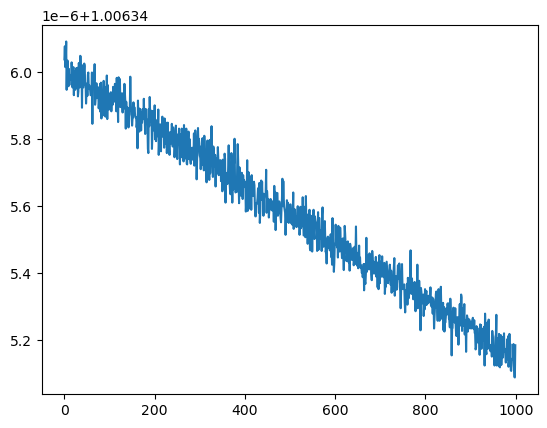

In [82]:
seq_len = 3
dataset = SeqWordDataset("../datasets/1984chapter.txt", seq_len=seq_len)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, drop_last=True)

n_input = len(dataset.unique_words)
rnn = RNN(num_inputs=n_input, num_hidden=200, num_outputs=n_input).to('cuda')

opt = torch.optim.SGD(rnn.parameters(), 0.1)

losses = []

for i in range(1000):
    batch_loss = []
    for batch in dataloader:
        batch_X = batch[:, :seq_len].transpose(0, 1)
        batch_y = batch[:, seq_len:]
        
        opt.zero_grad()
        y_pred, _ = rnn(batch_X)
        # print(y_pred.shape, batch_y.shape)
        loss = F.cross_entropy(y_pred, batch_y)
        # break
        
        loss.backward()
        # clip_gradients(10, rnn)
        opt.step()

        batch_loss.append(torch.exp(loss.detach()).item()) # perplexity metric
    # break
    losses.append(np.sum(batch_loss) / len(batch_loss))

plt.plot(losses)

In [83]:
preds = rnn.predict("the", 20, dataset.encoding, dataset.unique_words)
preds

'the guesswork colonies do do do do do do do do do do do do do do do do do do'

## Sequence to character RNN model

In [44]:
from torch.utils.data import DataLoader, Dataset
import re

class Vocab:
    def __init__(self, corpus: str) -> None:
        self.freqs = dict(zip(*np.unique(list(corpus.lower()), return_counts=True)))
        self.itos = np.unique(list(corpus) + ['.'])
        self.emb_size = self.itos.shape[0]
        self.emb = {k : i for i, k in enumerate(self.itos)}

class VocabDataset(Dataset):
    def __init__(self, file_path: str, seq_len=3) -> None:
        super().__init__()
        self.seq_len = seq_len
        f = open(file_path, 'r')
        self.corpus = f.read().lower()
        self.corpus = re.sub('[^A-Za-z]+', ' ', self.corpus)
        self.vocab = Vocab(self.corpus)

        self.corpus = self.corpus.split()

        self.X = []
        self.Y = []
        for w in self.corpus:
            context = [self.vocab.emb['.']]*seq_len
            for c in w + '.':
                ix = self.vocab.emb[c]
                self.X.append(context)
                self.Y.append(ix)
                context = context[1:] + [ix]
                
        self.X = torch.tensor(self.X)
        self.Y = torch.tensor(self.Y)
        
    def __getitem__(self, index):
        return self.X[index], self.Y[index]

    def __len__(self):
        return len(self.Y)


class RNN2char(nn.Module):
    def __init__(self, num_inputs: int, num_hidden: int, num_outputs: int) -> None:
        super().__init__()
        self.out_size = num_outputs
        self.num_inputs = num_inputs
        self.rnn = nn.RNN(num_inputs, num_hidden)
        self.out = nn.Sequential(nn.Linear(num_hidden, num_outputs), nn.Softmax(dim=2))
    
    def forward(self, X: torch.Tensor, H: torch.Tensor = None):
        inputs = F.one_hot(X, num_classes=self.num_inputs).type(torch.float32)
        outputs, H = self.rnn(inputs, H) # input: (seq_len, batch_size, emb_size)
        return self.out(H), H

    def predict(self, prefix: str, num_preds: int, vocab: Vocab):
        prefix = list(prefix.lower())
        H, outputs = None, [vocab.emb[prefix[0]]]

        for i in range(len(prefix) + num_preds - 1):
            # print(outputs[-1].shape)
            Y, H = self.forward(torch.tensor(outputs[-1]).view(1, 1).to('cuda'), H)
            # print(Y.shape, H.shape)

            if i < len(prefix) - 1:
                outputs.append(vocab.emb[prefix[i+1]])
            else:
                outputs.append(Y.argmax(dim=2).item())
        
        return ''.join([vocab.itos[y] for y in outputs])

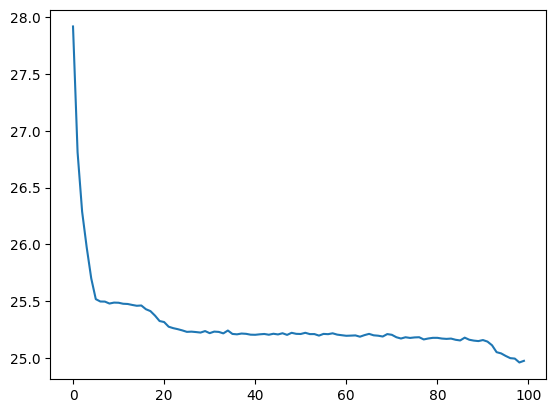

In [45]:
seq_len = 3
dataset = VocabDataset("../datasets/pokemon_names.txt", seq_len=seq_len)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True, drop_last=True)

n_input = dataset.vocab.emb_size
rnn = RNN2char(num_inputs=n_input, num_hidden=200, num_outputs=n_input).to('cuda')

opt = torch.optim.SGD(rnn.parameters(), 0.1)

losses = []

for i in range(100):
    batch_loss = []
    for batch_X, batch_y in dataloader:
        batch_X, batch_y = batch_X.to('cuda'), F.one_hot(batch_y, num_classes=n_input).type(torch.float32).to('cuda')
        
        opt.zero_grad()
        y_pred, _ = rnn(batch_X.T)
        # print(y_pred.view(-1, n_input).shape, batch_y.shape)
        loss = F.cross_entropy(y_pred.view(-1, n_input), batch_y)
        # break
        
        loss.backward()
        # clip_gradients(10, rnn)
        opt.step()

        batch_loss.append(torch.exp(loss.detach()).item()) # perplexity metric
    # break
    losses.append(np.sum(batch_loss) / len(batch_loss))

plt.plot(losses)

In [83]:
rnn.predict('charizard', 20, dataset.vocab)

'charizard....................'